# The goal is to find books similar to Lord of the rings

In [1]:
#Importing libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import spatial
from numpy.linalg import norm

In [2]:
#importing data
book_df = pd.read_csv('../input/books-ratings/BX-Books.csv', sep = ';', error_bad_lines=False, encoding="latin-1") 
ratings_df = pd.read_csv('../input/books-ratings/BX-Book-Ratings.csv', sep = ';', error_bad_lines=False, encoding="latin-1")
user_df = pd.read_csv('../input/books-ratings/BX-Users.csv', sep = ';', error_bad_lines=False, encoding="latin-1")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 

# Having a glimpse at dataframes
* Size
* Variables (columns)

In [3]:
print(book_df.shape)
book_df.head(2)

(271360, 8)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [4]:
print(ratings_df.shape)
ratings_df.head(2)
ratings_df['Book-Rating'].isnull().values.any()

(1149780, 3)


False

In [5]:
print(user_df.shape)
user_df.head(2)

(278858, 3)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


# First toughts
   * **Cluster analysis** - divide books into clusters based on book's attributes, books in the same cluster as LotR will be the ones recommended
       * Availeble data doesn't provide much information about book's content -> webscraping more data? -> too complicated -> looking for different approach
   * **Collaborative filtering**
       * Seemed suitable for this task. Especialy item-2-item collaborative filtering
    

# Calculating mean rating and ratings count for each book
* explicit (1-10) x implicit ratings (0)
* mean rating "Book-Rating" is mean explicit rating. Equel to NaN if there are just implicit ratings
* num_of_ratings - count of explicit ratings
* num_of_all_ratings - count of both types of ratings

In [6]:
ratings = pd.DataFrame(ratings_df.groupby('ISBN')['Book-Rating'].count())
ratings['num_of_ratings'] = pd.DataFrame(ratings_df.replace(0,np.NaN).groupby('ISBN')['Book-Rating'].count())
ratings['Average-Rating'] = pd.DataFrame(ratings_df.replace(0,np.NaN).groupby('ISBN')['Book-Rating'].mean())
ratings = ratings.rename(columns={'Book-Rating':'num_of_all_ratings'})
print(ratings.shape)
print(pd.Series(ratings['num_of_ratings']==0).sum())
ratings.head(10)

(340556, 3)
154583


,num_of_all_ratings,num_of_ratings,Average-Rating
ISBN,,,
0330299891,2,1,6.0
0375404120,2,1,3.0
0586045007,1,0,NaN
9022906116,2,1,7.0
9032803328,1,0,NaN
9044922564,1,0,NaN
9044922572,1,0,NaN
9044922718,1,0,NaN
9044923161,1,0,NaN


In [7]:
print(ratings['num_of_all_ratings'].value_counts().sort_index().head(5))
print(ratings['num_of_all_ratings'].value_counts().sort_index().tail(5))
print(ratings['num_of_ratings'].value_counts().sort_index().head(5))
print(ratings['num_of_ratings'].value_counts().sort_index().tail(5))

1    197045
2     59664
3     25976
4     14106
5      9008
Name: num_of_all_ratings, dtype: int64
723     1
732     1
883     1
1295    1
2502    1
Name: num_of_all_ratings, dtype: int64
0    154583
1    129621
2     26261
3     10173
4      5383
Name: num_of_ratings, dtype: int64
333    1
383    1
487    1
581    1
707    1
Name: num_of_ratings, dtype: int64


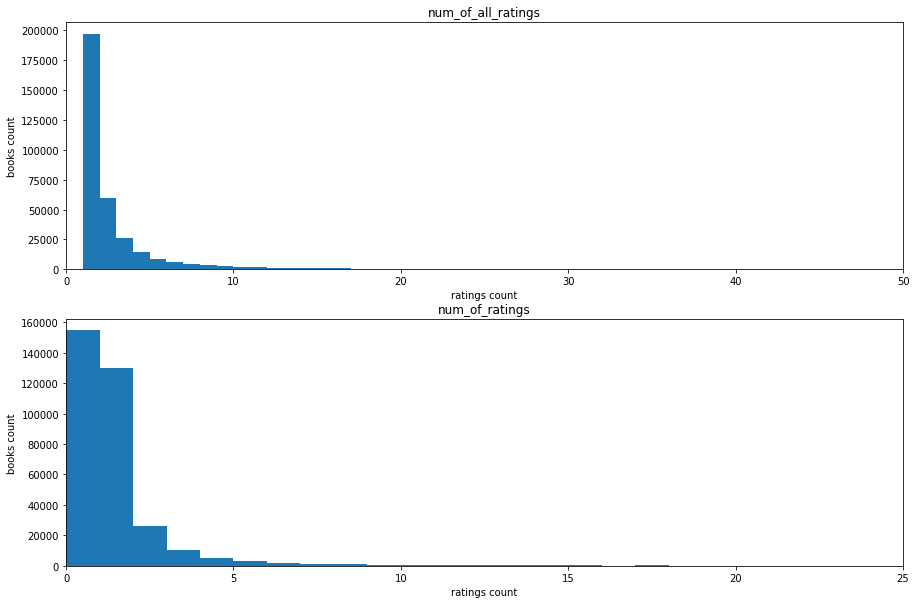

In [8]:
fig, ax = plt.subplots(2,1,figsize = (15,10))
ax[0].hist(ratings['num_of_all_ratings'], bins = ratings['num_of_all_ratings'].value_counts().sort_index().index[-1])
ax[0].set_xlim(0,50)
ax[0].set_xlabel('ratings count')
ax[0].set_ylabel('books count')
ax[0].set_title('num_of_all_ratings')
ax[1].hist(ratings['num_of_ratings'], bins = ratings['num_of_ratings'].value_counts().sort_index().index[-1])
ax[1].set_title('num_of_ratings')
ax[1].set_xlabel('ratings count')
ax[1].set_ylabel('books count')
ax[1].set_xlim(0,25)
plt.show()

Text(0, 0.5, 'Count')

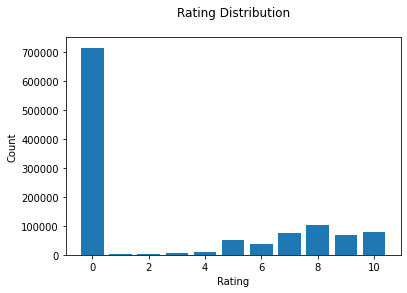

In [9]:
fig, ax = plt.subplots()
ax.bar(ratings_df['Book-Rating'].value_counts().sort_index().index, ratings_df['Book-Rating'].value_counts().sort_index().values)
ax.set_title('Rating Distribution\n')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')


# Findings
   * Most of the ratings are implicit ratings (=0), aprox. 700,000 out of 1,149,780 ratings
       * Exclusion of implicit ratings might lead to huge data loss. I should find way how to deal with implicit ratings
   * Majority of books have less than 10 implicit ratings and less than 5 explicit ratings
       * It will lead to sparsity of user-item matrix ('book_mat') later on

# LotR books
* Average ratings and ratings counts for Lotr books
* There are 119 LotR books
* Simplification: I will look for similar books to The Fellowship of the Ring (The Lord of the Rings), ISBN-0345339681
    * There are more than one publishments of The Fellowship of the Ring. I should have combine these in order to get more ratigs for this book. Unfortunately I noticed this issue too late
    * Or combine all LotR books and work with it as only 1 book

In [10]:
books_merged = ratings.merge(book_df[['ISBN','Book-Title']], left_on = 'ISBN', right_on = 'ISBN').sort_values('num_of_ratings', ascending = False)
books_merged[books_merged['Book-Title'].str.contains("Lord of the Rings", case=False, regex=False)]

,ISBN,num_of_all_ratings,num_of_ratings,Average-Rating,Book-Title
43238,0345339681,281,161,8.739130,The Hobbit : The Enchanting Prelude to The Lor...
43239,0345339703,257,131,8.839695,The Fellowship of the Ring (The Lord of the Ri...
43240,0345339711,177,83,9.120482,"The Two Towers (The Lord of the Rings, Part 2)"
43241,0345339738,173,77,9.402597,"The Return of the King (The Lord of the Rings,..."
129842,0618002227,63,43,9.093023,The Fellowship of the Ring (The Lord of the Ri...
...,...,...,...,...,...
130063,0618154019,3,0,NaN,The Fellowship of the Ring Visual Companion (T...
130206,0618345841,1,0,NaN,The Lord of the Rings
130208,0618346260,1,0,NaN,"The Two Towers (The Lord of the Rings, Part 2)"
130164,0618260226,1,0,NaN,The Making of the Movie Trilogy (The Lord of t...


# Filtering ratings of users who rated LotR part 1
* Similarity will be calculated based on ratings of users who rated target book. Ratings of other users can be filtered out.
* 75,927 out of 1,149,780 ratings

In [11]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
target='0345339703'
users_filter = ratings_df[ratings_df['ISBN'].isin([target])]
users_filter
ratings_df = ratings_df[ratings_df['User-ID'].isin(users_filter['User-ID'])]
ratings_df.shape

(75927, 3)

# Number of ratings recalculation
* To get the count of ratings that will be used for similaritu calculation

In [13]:
ratings = pd.DataFrame(ratings_df.groupby('ISBN')['Book-Rating'].count())
ratings['num_of_ratings'] = pd.DataFrame(ratings_df.replace(0,np.NaN).groupby('ISBN')['Book-Rating'].count())
ratings['Average-Rating'] = pd.DataFrame(ratings_df.replace(0,np.NaN).groupby('ISBN')['Book-Rating'].mean())
ratings = ratings.rename(columns={'Book-Rating':'num_of_all_ratings'})
print(ratings.shape)
print(pd.Series(ratings['num_of_ratings']==0).sum())
ratings.head(10)

(52182, 3)
32354


,num_of_all_ratings,num_of_ratings,Average-Rating
ISBN,,,
9022906116,1,1,7.0
0 7336 1053 6,1,0,NaN
0000000000,1,1,9.0
00000000000,1,1,8.0
0000913154,1,1,8.0
0001055666,1,1,9.0
0001837397,1,0,NaN
0001841572,1,0,NaN
0001848445,1,0,NaN


# User - Book matrix
* rows - users; columns - books; values -ratings
* 257 users, 52,182 books

In [14]:
book_mat = ratings_df.pivot_table(index = 'User-ID', columns = 'ISBN', values = 'Book-Rating')
print(book_mat.shape)
book_mat.sample(5)

(257, 52182)


ISBN,9022906116,0 7336 1053 6,0000000000,00000000000,0000913154,0001055666,0001837397,0001841572,0001848445,0001900277,...,O446611638,O451203771,O77O428452,O805063196,O9088446X,ROO48580353,X000000000,ZR903CX0003,"\0432534220\""""","\2842053052\"""""
User-ID,,,,,,,,,,,,,,,,,,,,,
271558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data preparation for similarity calculation:
implicit ratings will be considered as neutral (mean) ratings not bad ratings (=0)
* Calculation of mean rating for each user.
    * Missing values (NaNs) and implicit ratings (=0) are not included into means calculation
* replacement of implicit ratings by user's mean rating (zeros in each row are replaced by row mean).
* **Centering:** for each row the row mean is substracted from row elements (transformed implcit ratings are included in calculation of row means)
    * conservative vs liberal raters, see paragraph "Adjusted cosine similarity" in http://files.grouplens.org/papers/www10_sarwar.pdf


In [15]:
#row means calculation
users_means = [0] * len(book_mat.index)
for i in range(len(book_mat.index)):
    users_means[i] = book_mat.iloc[i, :][book_mat.iloc[i, :] !=0].mean(skipna=True)

In [16]:
#replacement of implicit ratings by row means
for i in range(len(users_means)):
    book_mat.iloc[i, :]=book_mat.iloc[i, :].replace(0, users_means[i])

In [17]:
#centering
book_mat = book_mat.sub(book_mat.mean(axis=1, skipna=True), axis=0)

In [18]:
book_mat.mean(axis=1, skipna=True)

User-ID
1167      0.000000e+00
1903     -3.510670e-15
3556     -3.821859e-15
6102     -1.887379e-15
8759      0.000000e+00
              ...     
273110    1.152148e-14
274393    2.368476e-16
276050   -4.440892e-16
276313    0.000000e+00
278550   -5.921189e-16
Length: 257, dtype: float64

# Most similar books to The Fellowship of the Ring (ISBN 0345339703)
* Cosine similarity will be used as similarity metrics
* cossine_sim function
    * function that calculates cosine similarity between 2 arrays 

In [19]:
book_target_user_ratings = book_mat['0345339703']

In [20]:
def cosine_sim(df1, df2):

    df1na = df1.isna()
    df1clean = df1[~df1na]
    df2clean = df2[~df1na]

    df2na = df2clean.isna()
    df1clean = df1clean[~df2na]
    df2clean = df2clean[~df2na]
    
    sim = np.dot(df1clean, df2clean)/(norm(df1clean)*norm(df2clean))

    return sim

In [21]:
books_sim = [0] * len(book_mat.columns)
for i in range(len(book_mat.columns)):
        books_sim[i] = cosine_sim(book_target_user_ratings, book_mat.iloc[:, i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [22]:
coss_book_target = pd.DataFrame({'ISBN': book_mat.columns, 'cos_sim': books_sim})
coss_book_target.dropna(inplace = True)
coss_book_target = coss_book_target.merge(book_df[['ISBN','Book-Title']], left_on = 'ISBN', right_on = 'ISBN')
coss_book_target = coss_book_target.merge(ratings[['num_of_ratings','num_of_all_ratings', 'Average-Rating']], on = 'ISBN')
top_10_sim = coss_book_target[coss_book_target['num_of_ratings']>10].sort_values(['cos_sim'], ascending=[False]).head(10)
top_10_sim

,ISBN,cos_sim,Book-Title,num_of_ratings,num_of_all_ratings,Average-Rating
6958,0345339703,1.000000,The Fellowship of the Ring (The Lord of the Ri...,131,257,8.839695
6960,0345339738,0.804325,"The Return of the King (The Lord of the Rings,...",40,84,9.575000
6959,0345339711,0.522090,"The Two Towers (The Lord of the Rings, Part 2)",46,95,9.304348
15425,0439136369,0.468147,Harry Potter and the Prisoner of Azkaban (Book 3),13,19,9.692308
15379,0439064872,0.394087,Harry Potter and the Chamber of Secrets (Book 2),14,28,8.857143
33699,0812550706,0.371627,Ender's Game (Ender Wiggins Saga (Paperback)),12,14,9.416667
24506,059035342X,0.321316,Harry Potter and the Sorcerer's Stone (Harry P...,18,37,8.944444
6957,0345339681,0.285794,The Hobbit : The Enchanting Prelude to The Lor...,40,65,9.125000
13190,0385504209,0.225687,The Da Vinci Code,18,29,9.166667
6947,0345337662,0.168979,Interview with the Vampire,13,29,7.615385


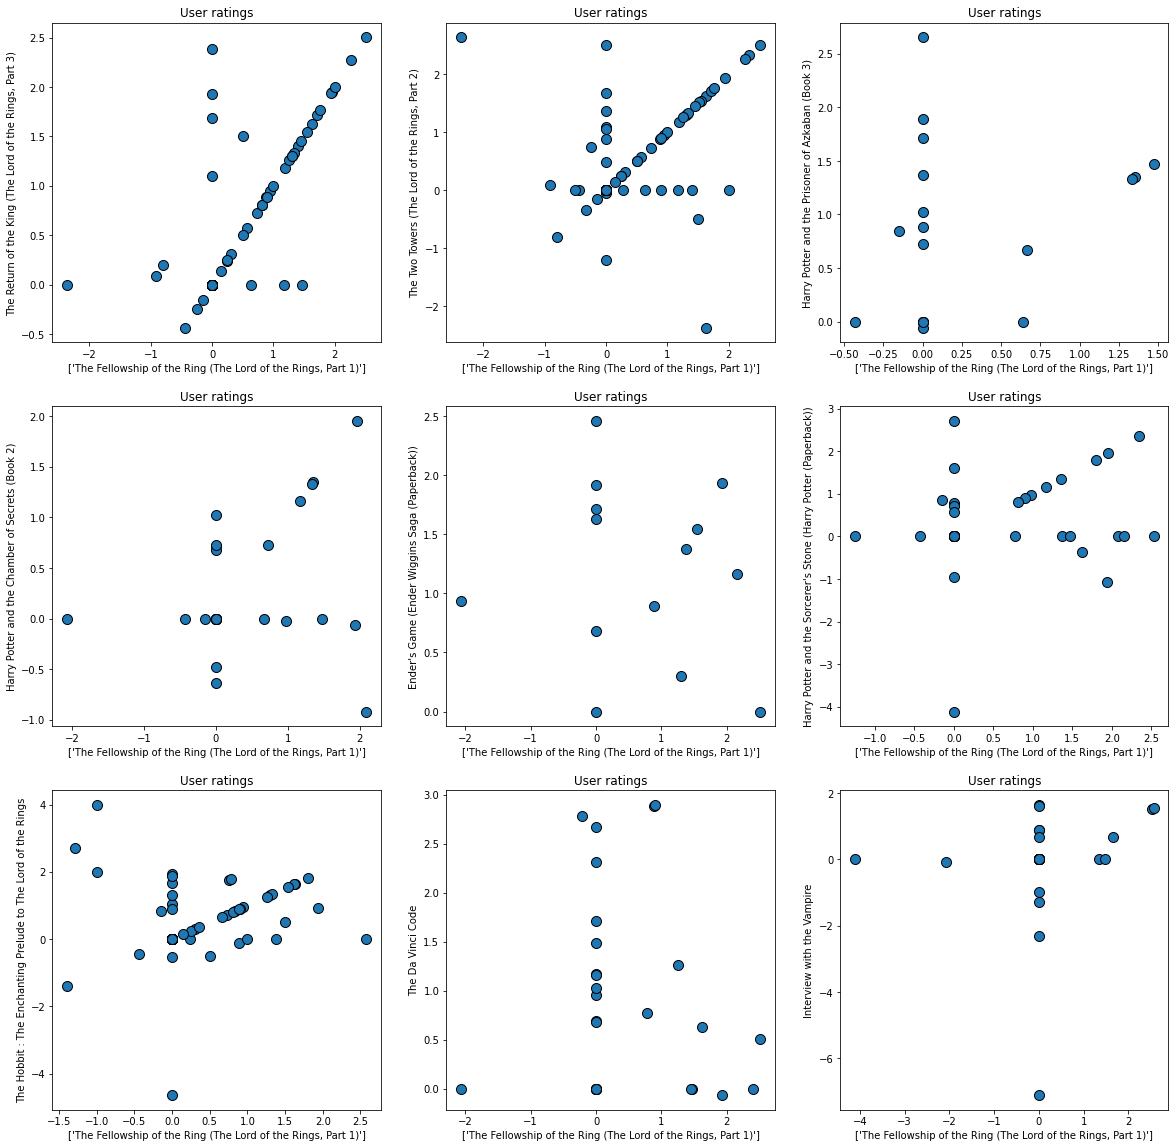

In [23]:
fig, axs = plt.subplots(3, 3, figsize = (20,20))

axs_x = [0,1,2,0,1,2,0,1,2]
axs_y = [0,0,0,1,1,1,2,2,2]
ind = range(1,10,1)

for ax_x, ax_y, ind in zip(axs_x, axs_y, ind):
    axs[ax_y,ax_x].scatter(book_mat['0345339703'], book_mat[top_10_sim['ISBN'].iloc[ind]], s=100, facecolor='C0', edgecolor='k')
    axs[ax_y,ax_x].set_ylabel(top_10_sim['Book-Title'].iloc[ind])
    axs[ax_y,ax_x].set_title('User ratings')
    axs[ax_y,ax_x].set_xlabel(list(coss_book_target['Book-Title'][coss_book_target['ISBN'] == '0345339703']))

# TODO
* Results evaluation
    * Calculate metric that will enable comparison of diferent aproaches
    * e.g prediction calculation (see http://files.grouplens.org/papers/www10_sarwar.pdf) and calculation of MAE
* Agregate books in order to get more ratings
* find a better way how to deal with implicit ratings
* combine all LotR book in order to get more data
* try other similarity metrics
